In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import time
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.set_random_seed(71)
np.random.seed(71)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST-data')
train_imgs = mnist.train.images
train_labels = mnist.train.labels
test_imgs = mnist.test.images
test_labels = mnist.test.labels
valid_imgs = mnist.validation.images
valid_labels = mnist.validation.labels

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
batch_size = 32
img_width = 28
img_height = 28
n_channel = 1
dropout_rate = 0.1
output_size = 10

n_epoch = 50
n_train_iteration = len(train_imgs) // batch_size
n_eval_train = n_train_iteration // 3
n_eval_valid = len(valid_imgs) // batch_size
n_eval_test = len(test_imgs) // batch_size
print_every = 100

In [5]:
class conv_block(Layer):
    def __init__(self, num_filter, num_conv):
        self.num_filter = num_filter
        self.num_conv = num_conv
        self.batch_norm1 = tf.layers.BatchNormalization(axis=3, name='batch1')
        self.batch_norm2 = tf.layers.BatchNormalization(axis=3, name='batch2')
        self.batch_norm3 = tf.layers.BatchNormalization(axis=3, name='batch3')
        self.conv1 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name='conv1')
        self.conv2 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name='conv2')
        self.conv3 = tf.layers.Conv2D(filters=self.num_filter, kernel_size=3, padding='same', activation=tf.nn.relu, name='conv3')
        self.maxpool = tf.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid', name='maxpool')
    
    def __call__(self, inputs, is_train):
        conv_layer = self.batch_norm1(inputs, training=is_train)
        conv_layer = self.conv1(conv_layer)
        conv_layer = self.batch_norm2(conv_layer, training=is_train)
        conv_layer = self.conv2(conv_layer)
        if self.num_conv == 3:
            conv_layer = self.batch_norm3(conv_layer, training=is_train)
            conv_layer = self.conv3(conv_layer)
        conv_layer = self.maxpool(conv_layer)
        return conv_layer

In [6]:
class Test_Model(Layer):
    def __init__(self):
        self.conv_64 = conv_block(64, 3)
        self.conv_128 = conv_block(128, 3)
        self.dens_1 = tf.layers.Dense(units=512, activation=tf.nn.relu, name='dens1')
        self.dens_2 = tf.layers.Dense(units=1024, activation=tf.nn.relu, name='dens2')
        self.drop_1 = tf.layers.Dropout(rate=dropout_rate)
        self.drop_2 = tf.layers.Dropout(rate=dropout_rate)
        self.logit = tf.layers.Dense(units=output_size)
    
    def __call__(self, inputs, is_train):
        input_layer = tf.reshape(inputs, [batch_size, img_height, img_width, n_channel])
        conv_layer1 = self.conv_64(input_layer, is_train)
        conv_layer2 = self.conv_128(conv_layer1, is_train)
        flatten_layer = tf.layers.flatten(conv_layer2)
        dens_layer1 = self.dens_1(flatten_layer)
        drop_layer1 = self.drop_1(dens_layer1, training=is_train)
        dens_layer2 = self.dens_2(drop_layer1)
        drop_layer2 = self.drop_2(dens_layer2, training=is_train)
        logits = self.logit(drop_layer2)
        return logits

In [7]:
test_model = Test_Model()

In [8]:
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, 784])
y = tf.placeholder(dtype=tf.int32, shape = [batch_size])
is_train = tf.placeholder(dtype = tf.bool)

y_onehot = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
# logits = vgg_model(X, is_train)
logits = test_model(X, is_train)
loss = tf.losses.softmax_cross_entropy(y_onehot, logits)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-2
learning_rate = tf.train.exponential_decay(learning_rate=starter_learning_rate, decay_rate=0.96, global_step=global_step, decay_steps=n_train_iteration)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

#train_op = optimizer.minimize(loss, global_step=global_step)
predictions = tf.argmax(logits, axis=1)
accuracy = tf.metrics.accuracy(y, predictions)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_op = optimizer.minimize(loss, global_step=global_step)

In [9]:
def train():
#     n_iteration = 2
    for ite in range(n_train_iteration):
        images,labels = mnist.train.next_batch(batch_size)
        _,_,_,loss_value,_ = sess.run([global_step, y_onehot, logits, loss, train_op],feed_dict={X:images, y:labels, is_train:True})
        if (ite+1)%print_every == 0:
            print('[ite %d]loss=%f'%(ite+1, loss_value))

def evaluation():
    train_loss,valid_loss,test_loss = 0.0,0.0,0.0
    train_acc,valid_acc,test_acc = 0.0,0.0,0.0
    for ite in range(n_eval_train):
        images,labels = mnist.train.next_batch(batch_size)
        _,_,loss_value,_,acc = sess.run([y_onehot, logits, loss, predictions, accuracy], feed_dict={X:images, y:labels, is_train:False})
        train_loss += loss_value
        train_acc += acc[0]

    train_loss /= n_eval_train
    train_acc /= n_eval_train
    
    for ite in range(n_eval_valid):
        images,labels = mnist.validation.next_batch(batch_size)
        _,_,loss_value,_,acc = sess.run([y_onehot, logits, loss, predictions, accuracy], feed_dict={X:images, y:labels, is_train:False})
        valid_loss += loss_value
        valid_acc += acc[0]
    valid_loss /= n_eval_valid
    valid_acc /= n_eval_valid
    
    for ite in range(n_eval_test):
        images,labels = mnist.test.next_batch(batch_size)
        _,_,loss_value,_,acc = sess.run([y_onehot, logits, loss, predictions, accuracy], feed_dict={X:images, y:labels, is_train:False})
        test_loss += loss_value
        test_acc += acc[0]
    test_loss /= n_eval_test
    test_acc /= n_eval_test
    
    return train_loss,valid_loss,test_loss,train_acc,valid_acc,test_acc
        

In [10]:
trainloss_list = []
validloss_list = []
testloss_list = []
trainacc_list = []
validacc_list = []
testacc_list = []

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3

with tf.Session() as sess:
    print('Start:'+time.strftime("%H:%M:%S", time.localtime()))
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    for epoch in range(n_epoch):
        train()
        trl,val,tel,tra,vaa,tea = evaluation()
        trainloss_list.append(trl)
        validloss_list.append(val)
        testloss_list.append(tel)
        trainacc_list.append(tra)
        validacc_list.append(vaa)
        testacc_list.append(tea)
        print('[Epoch %d]'%(epoch+1)+time.strftime("%H:%M:%S", time.localtime())+'  learning_rate=%f'%(sess.run(optimizer._learning_rate)))
        print('train_loss=%f, train_acc=%f, valid_loss=%f, valid_acc=%f, test_loss=%f, test_acc=%f'%(trl,tra,val,vaa,tel,tea))

Start:14:54:54
[ite 100]loss=0.096626
[ite 200]loss=0.053069
[ite 300]loss=0.026442
[ite 400]loss=0.376188
[ite 500]loss=0.007807
[ite 600]loss=0.068295
[ite 700]loss=0.500068
[ite 800]loss=0.038491
[ite 900]loss=0.205049
[ite 1000]loss=0.189530
[ite 1100]loss=0.147465
[ite 1200]loss=0.013303
[ite 1300]loss=0.039846
[ite 1400]loss=0.113117
[ite 1500]loss=0.022531
[ite 1600]loss=0.007996
[ite 1700]loss=0.019978
[Epoch 1]14:55:16  learning_rate=0.009600
train_loss=0.031700, train_acc=0.987745, valid_loss=0.041507, valid_acc=0.989680, test_loss=0.034150, test_acc=0.989292
[ite 100]loss=0.006271
[ite 200]loss=0.001705
[ite 300]loss=0.021907
[ite 400]loss=0.029577
[ite 500]loss=0.001293
[ite 600]loss=0.134881
[ite 700]loss=0.074589
[ite 800]loss=0.001024
[ite 900]loss=0.020517
[ite 1000]loss=0.019141
[ite 1100]loss=0.004403
[ite 1200]loss=0.087833
[ite 1300]loss=0.028368
[ite 1400]loss=0.162199
[ite 1500]loss=0.022828
[ite 1600]loss=0.037939
[ite 1700]loss=0.007313
[Epoch 2]14:55:36  learni

[ite 1500]loss=0.000411
[ite 1600]loss=0.000481
[ite 1700]loss=0.000076
[Epoch 15]15:00:00  learning_rate=0.005421
train_loss=0.000438, train_acc=0.995893, valid_loss=0.024821, valid_acc=0.995961, test_loss=0.018721, test_acc=0.995942
[ite 100]loss=0.000052
[ite 200]loss=0.001947
[ite 300]loss=0.000198
[ite 400]loss=0.003300
[ite 500]loss=0.000720
[ite 600]loss=0.000126
[ite 700]loss=0.000753
[ite 800]loss=0.000211
[ite 900]loss=0.000020
[ite 1000]loss=0.003797
[ite 1100]loss=0.000082
[ite 1200]loss=0.000118
[ite 1300]loss=0.000027
[ite 1400]loss=0.000301
[ite 1500]loss=0.000038
[ite 1600]loss=0.000030
[ite 1700]loss=0.032359
[Epoch 16]15:00:21  learning_rate=0.005204
train_loss=0.000383, train_acc=0.995997, valid_loss=0.024150, valid_acc=0.996058, test_loss=0.017085, test_acc=0.996038
[ite 100]loss=0.000741
[ite 200]loss=0.000157
[ite 300]loss=0.001770
[ite 400]loss=0.000105
[ite 500]loss=0.001341
[ite 600]loss=0.001162
[ite 700]loss=0.000031
[ite 800]loss=0.000358
[ite 900]loss=0.002

[ite 500]loss=0.000019
[ite 600]loss=0.000105
[ite 700]loss=0.000010
[ite 800]loss=0.000053
[ite 900]loss=0.000309
[ite 1000]loss=0.000223
[ite 1100]loss=0.000052
[ite 1200]loss=0.000032
[ite 1300]loss=0.000148
[ite 1400]loss=0.000213
[ite 1500]loss=0.000012
[ite 1600]loss=0.000064
[ite 1700]loss=0.000637
[Epoch 30]15:05:04  learning_rate=0.002939
train_loss=0.000075, train_acc=0.996769, valid_loss=0.026188, valid_acc=0.996795, test_loss=0.019145, test_acc=0.996779
[ite 100]loss=0.000040
[ite 200]loss=0.000055
[ite 300]loss=0.000004
[ite 400]loss=0.000316
[ite 500]loss=0.001225
[ite 600]loss=0.000033
[ite 700]loss=0.000068
[ite 800]loss=0.000009
[ite 900]loss=0.000006
[ite 1000]loss=0.000028
[ite 1100]loss=0.000010
[ite 1200]loss=0.000249
[ite 1300]loss=0.000003
[ite 1400]loss=0.000013
[ite 1500]loss=0.000234
[ite 1600]loss=0.000018
[ite 1700]loss=0.000127
[Epoch 31]15:05:24  learning_rate=0.002821
train_loss=0.000090, train_acc=0.996797, valid_loss=0.022563, valid_acc=0.996820, test_l

[ite 100]loss=0.000083
[ite 200]loss=0.000012
[ite 300]loss=0.000891
[ite 400]loss=0.000524
[ite 500]loss=0.000014
[ite 600]loss=0.000043
[ite 700]loss=0.000001
[ite 800]loss=0.000037
[ite 900]loss=0.000010
[ite 1000]loss=0.000009
[ite 1100]loss=0.000746
[ite 1200]loss=0.000132
[ite 1300]loss=0.000009
[ite 1400]loss=0.000019
[ite 1500]loss=0.000900
[ite 1600]loss=0.000021
[ite 1700]loss=0.000003
[Epoch 45]15:10:05  learning_rate=0.001593
train_loss=0.000059, train_acc=0.997078, valid_loss=0.024513, valid_acc=0.997094, test_loss=0.019684, test_acc=0.997080
[ite 100]loss=0.000041
[ite 200]loss=0.000009
[ite 300]loss=0.000005
[ite 400]loss=0.000473
[ite 500]loss=0.000028
[ite 600]loss=0.000004
[ite 700]loss=0.000491
[ite 800]loss=0.000006
[ite 900]loss=0.000041
[ite 1000]loss=0.000178
[ite 1100]loss=0.000130
[ite 1200]loss=0.000178
[ite 1300]loss=0.000006
[ite 1400]loss=0.000334
[ite 1500]loss=0.000504
[ite 1600]loss=0.000008
[ite 1700]loss=0.000030
[Epoch 46]15:10:23  learning_rate=0.001

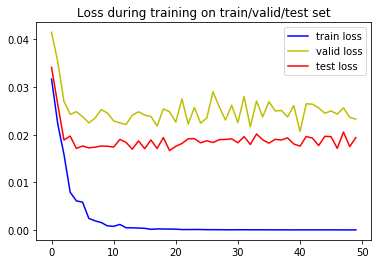

In [11]:
plt.plot(range(n_epoch), trainloss_list, label='train loss', color='b')
plt.plot(range(n_epoch), validloss_list, label='valid loss', color='y')
plt.plot(range(n_epoch), testloss_list, label='test loss',color='r')
plt.title('Loss during training on train/valid/test set')
plt.legend(loc='upper right')
plt.show()

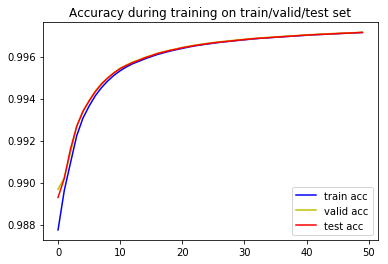

In [12]:
plt.plot(range(n_epoch), trainacc_list, label='train acc', color='b')
plt.plot(range(n_epoch), validacc_list, label='valid acc', color='y')
plt.plot(range(n_epoch), testacc_list, label='test acc',color='r')
plt.title('Accuracy during training on train/valid/test set')
plt.legend(loc='lower right')
plt.show()

In [14]:
max_valid_acc_epoch = np.argmax(validacc_list)
print('The maximum accuracy on validation set occurs after %d epochs'%(max_valid_acc_epoch+1))
print('Train: loss %f, accuracy %f, error rate %f'%(trainloss_list[max_valid_acc_epoch], trainacc_list[max_valid_acc_epoch], 1-trainacc_list[max_valid_acc_epoch]))
print('Valid: loss %f, accuracy %f, error rate %f'%(validloss_list[max_valid_acc_epoch], validacc_list[max_valid_acc_epoch], 1-validacc_list[max_valid_acc_epoch]))
print('Test : loss %f, accuracy %f, error rate %f'%(testloss_list[max_valid_acc_epoch], testacc_list[max_valid_acc_epoch], 1-testacc_list[max_valid_acc_epoch]))

The maximum accuracy on validation set occurs after 50 epochs
Train: loss 0.000054, accuracy 0.997144, error rate 0.002856
Valid: loss 0.023260, accuracy 0.997158, error rate 0.002842
Test : loss 0.019417, accuracy 0.997149, error rate 0.002851
